In [568]:
import pyomo.environ as pe
import pyomo.dae as dae
import numpy as np
from pyomo.opt import SolverStatus, TerminationCondition

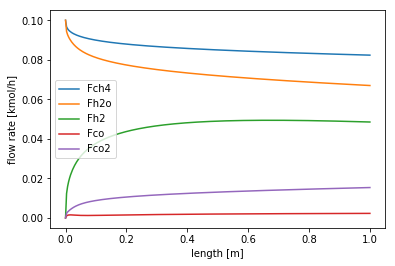

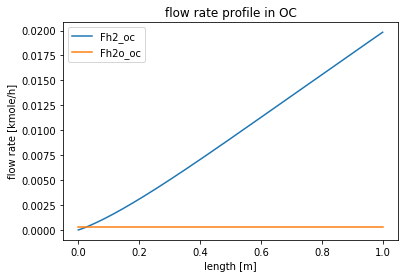

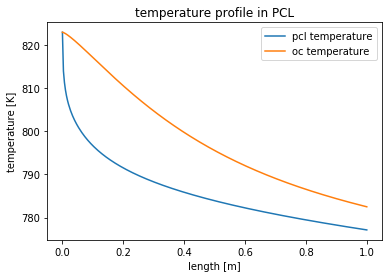

In [2]:
import numpy as np 
from scipy.integrate import odeint
from scipy.optimize import fsolve



Dis_num = 100
Col_num = 3
# cocurrent case
R = 0.0083144621  # kJ/(K*mol) gas constant 
R_ = 8.3144621    # J/(K*mol)  gas constant 
# reactor parameter
d_cata = 5e-3                                      # m  catalyst diameter
rho_ave = 1.6                                      # kg/m3 pcl gas average density
rho_oc_ave = 0.1345                                # kg/m3 oc gas average density
mu_ave = 2.97e-5                                   # Pa*s pcl gas average viscosity
mu_oc_ave = 1.98e-5                                # Pa*s oc gas average viscosity
epsilon = 0.85                                     # bed void fraction
radius2 = 21e-3                                    # m pcl radius
radius1 = 7e-3                                     # m oc radius
Ac_pcl = (np.pi * radius2**2 - np.pi * radius1**2) # m^2 cross sectional area of pcl layer
Ac_oc = np.pi * radius1**2                         # m^2 cross sectional area of oc layer
rho_cata = 1820# kg/m3 catalyst density, calculated from catalyst weight given in Comsol 
L1 = 1                                          # m reactor length

# kinetic parameters from xu and froment
Ak1 = 4.255e15   # pre-exponential factor of rate constant of reaction 1
Ak2 = 1.955e6    # pre-exponential factor of rate constant of reaction 2
Ak3 = 1.02e15    # pre-exponential factor of rate constant of reaction 3
E1 = 240.1       # kJ/mol activation energy of reaction 1
E2 = 67.13       # kJ/mol activation energy of reaction 2
E3 = 243.9       # kJ/mol activation energy of reaction 3
dHco = -70.65    # kJ/mol enthalpy of adsorption of CO
dHh2 = -82.9     # kJ/mol enthalpy of adsorption of H2
dHch4 = -38.28   # kJ/mol enthalpy of adsorption of CH4
dHh2o = 88.68    # kJ/mol enthalpy of adsorption of H2O
AKco = 8.23e-5   # pre-exponential factor of adsorption constant of CO
AKh2 = 6.121e-9  # pre-exponential factor of adsorption constant of H2
AKch4 = 6.65e-4  # pre-exponential factor of adsorption constant of CH4
AKh2o = 1.77e5   # pre-exponential factor of adsorption constant of H2O
dH1 = -223078    # J/mol enthalpy of reaction 1
dH2 = 36584      # J/mol enthalpy of reaction 2
dH3 = -186494    # J/mol enthalpy of reaction 3


# flow rate parameters
Pt0 = 10            # bar inlet pressure of pcl layer
Pt = 10
Pt0_oc = 1         # bar inlet pressure of oc layer
Pt_oc = 1

T0 = 823    # K pcl inlet temperature
T0_oc = 823 # K oc inlet temperature

Fch40 = 0.1 # kmol/hr  initial condition, inlet of CH4
Fh2o0 = 0.1 
Fh20 = 1e-5            # kmol/h H2 pcl inlet flow rate 
Fco0 = 1e-5              # kmol/h CO pcl inlet flow rate 
Fco20 = 1e-5            # kmol/h CO2 pcl inlet flow rate 

Fh20_oc = 1e-5   # kmol/h H2 oc inlet flow rate 
Fh2o0_oc = 3e-4  # kmol/h H2O oc inlet flow rate 


Ft0 = Fch40+Fh2o0+Fh20+Fco0+Fco20
Ft0_oc = Fh2o0_oc+Fh20_oc

u_pcl = Ft0*R_*T0/(Ac_pcl*Pt0*1e5)*1000/3600
u_oc = Ft0_oc*R_*T0/(Ac_oc*Pt0_oc*1e5)*1000/3600
# nu_in = u_pcl*Ac_pcl           # m3/s pcl inlet volumetric flow rate
# nu_oc_in = u_oc*Ac_oc       # m3/s pcl inlet volumetric flow rate






# # heat parameter
Cp_ave = 41.06       # J/(mol*K) gas mixture specific heat of pcl
Cp_oc_ave = 36.24    # J/(mol*K) gas mixture specific heat of oc
k_ave = 0.126        # W/(m*K)   average gas mixture thermal conductivity at pcl
k_oc_ave = 0.465     # W/(m*K)   average gas mixture thermal conductivity at oc


Pr = mu_ave*Cp_ave/k_ave                       # Prandtl number at pcl
Pr_oc = mu_oc_ave*Cp_oc_ave/k_oc_ave           # Prandtl number at oc
Re = rho_ave*u_pcl*(radius2-radius1)*2/mu_ave   # Reynolds number at pcl
Re_oc = rho_oc_ave*u_oc*radius1*2/mu_oc_ave    # Reynolds number at oc
h = 1.6 * k_ave/(2*radius2)*(2+0.644*Pr**(1/3)*(Re/epsilon)**1/2*(1+(0.557*(Re/epsilon)**0.3*Pr**(2/3))/(1+2.443*(Re/epsilon)**-0.1*(Pr**(2/3)-1)))**(1/2)) # W/(m*K) pcl convective heat transfer coefficient
h_oc = 1.45*k_oc_ave/(2*radius1)*Re_oc**0.8*Pr_oc**0.33  # W/(m*K) oc layer convective heat transfer coefficient


# membrane parameters
E_mem = 15700                           # J/mol membrane permeation energy
Q_mem = 1.2e-6/(1.01325)**0.5*3600/1000 # kmol/(m*h*bar) pre-exponential factor of membrane permeation
d_memb = 1e-6                           # m  membrane thickness  
# G = u_pcl*rho_ave                       # kg/(m^3*s)
# Rep = G*d_cata/mu_ave                   # practical Reynolds number
# f = 150 + 1.75*Rep/(1-epsilon)          # friction factor
eta1 = 0.07
eta2 = 0.07
eta3 = 0.06

def k1(T):        # kmol*bar^(1/2)/(kgcat*hr) rate constant of reaction 1
    return Ak1*np.exp(-E1/(R*T))
def k2(T):        # kmol/(kgcat*hr)           rate constant of reaction 2
    return Ak2*np.exp(-E2/(R*T))    
def k3(T):        # kmol*bar^(1/2)/(kgcat*hr) rate constant of reaction 3
    return Ak3*np.exp(-E3/(R*T)) 
def Kp1(T):       # bar^2   rate equilibrium constant of reaction 1
    return 1.198e17*np.exp(-26830/T)
def Kp2(T):       #  1      rate equilibrium constant of reaction 2
    return 1.767e-2*np.exp(4400/T)
def Kp3(T):       # bar^2   rate equilibrium constant of reaction 3
    return 2.117e15*np.exp(-22430/T)
def Kco(T):       # bar^-1  adsorption constant of CO
    return AKco*np.exp(-dHco/(R*T))
def Kh2(T):       # bar^-1  adsorption constant of H2
    return AKh2*np.exp(-dHh2/(R*T))
def Kch4(T):      # bar^-1  adsorption constant of CH4
    return AKch4*np.exp(-dHch4/(R*T))
def Kh2o(T):      # bar^-1  adsorption constant of H2O
    return AKh2o*np.exp(-dHh2o/(R*T))


# "ode" function takes in differiential variables and returns the differential equations involved
def ode(Y,Z):
    Fch4,Fh2o,Fh2,Fco,Fco2,Fh2_oc,Fh2o_oc,T,T_oc = Y  # list all the differiential variables

    Ft_oc = Fh2_oc+Fh2o_oc # total flow rate at oc = flow rate of H2 + flow rate of H2O
    Ft = Fch4 + Fh2o + Fh2 + Fco + Fco2 # total flow rate at pcl layer
    Pch4 = Fch4 / Ft * Pt  # patial pressure of CH4
    Ph2o = Fh2o / Ft * Pt  # patial pressure of H2O
    Ph2 = Fh2 / Ft * Pt    # patial pressure of H2
    Pco = Fco / Ft * Pt    # patial pressure of CO
    Pco2 = Fco2 / Ft * Pt  # patial pressure of CO2
    Ph2_oc = Fh2_oc / Ft_oc * Pt_oc  # patial pressure of H2 at oc layer
    Ph2o_oc = Fh2o_oc / Ft_oc * Pt_oc  # patial pressure of H2O at oc layer

    den = 1 + Kco(T) * Pco + Kh2(T) * Ph2 + Kh2o(T) * Ph2o / Ph2   # denominator in kinetics
    r1 = eta1*k1(T)*(Pch4*Ph2o/Ph2**2.5-Pco*Ph2**0.5/Kp1(T))/den**2 # kmol/(kgcat*h) rate law for reaction 1
    r2 = eta2*k2(T)*(Pco*Ph2o/Ph2-Pco2/Kp2(T))/den**2                    # kmol/(kgcat*h) rate law for reaction 2
    r3 = eta3*k3(T)*(Pch4*Ph2o**2/Ph2**3.5-Pco2*Ph2**0.5/Kp3(T))/den**2  # kmol/(kgcat*h) rate law for reaction 3
    J = Q_mem*np.exp(-E_mem/(R_*T))*(Ph2-Ph2_oc)/d_memb             # kmol/(h*m2) H2 flux

    # kmol/h / m  dF/dZ: flow rate change over reactor length
    dFch4 = (-r1-r3)*rho_cata*(1-epsilon)*Ac_pcl                    
    dFh2o = (-r1-r2-2*r3)*rho_cata*(1-epsilon)*Ac_pcl              
    dFh2 = (3*r1+r2+4*r3)*rho_cata*(1-epsilon)*Ac_pcl - J*2*np.pi*radius1  
    dFco2 = (r2+r3)*rho_cata*(1-epsilon)*Ac_pcl
    dFco = (r1-r2)*rho_cata*(1-epsilon)*Ac_pcl

    dFh2_oc = J*2*np.pi*radius1  # H2 oc flow rate = inward flux of H2 
    dFh2o_oc = 0   # water is not permeated through membrane, so it does not change
    
    Twall = h_oc/(h_oc+h)*T_oc+h/(h_oc+h)*T     # wall temperature    
    dT = (np.pi*2*radius1*h*(Twall - T)+Ac_pcl*1000/3600*rho_cata*(1-epsilon)*(dH1*r1+dH2*r2+dH3*r3))/(u_pcl*rho_ave*Cp_ave) # K/m pcl temperature change over reactor length
    dT_oc = (np.pi*2*radius1*h_oc*(Twall - T_oc))/(u_oc*rho_oc_ave*Cp_oc_ave) # K/m oc temperature change over reactor length


    return [dFch4,dFh2o,dFh2,dFco,dFco2,dFh2_oc,dFh2o_oc,dT,dT_oc]
        
Y0 = [Fch40,Fh2o0,Fh20,Fco0,Fco20,Fh20_oc,Fh2o0_oc,T0,T0_oc] #left boundary conditions 
Zspan = np.linspace(0,L1,Dis_num*Col_num+1) # reactor length discretization

# call odeint to solve the ODE funtions, returns the differential variable value at each discritized length
sol = odeint(ode,Y0,Zspan)  

# collect results of differential variables value
Fch4 = sol[:, 0]
Fh2o = sol[:, 1]
Fh2 = sol[:, 2]
Fco = sol[:, 3]
Fco2 = sol[:,4]
Fh2_oc = sol[:,5]
Fh2o_oc = sol[:,6]
T = sol[:,7]
T_oc = sol[:,8]



Ft_oc = Fh2_oc+Fh2o_oc # total flow rate at oc = flow rate of H2 + flow rate of H2O
Ft = Fch4 + Fh2o + Fh2 + Fco + Fco2 # total flow rate at pcl layer
Pch4 = Fch4 / Ft * Pt  # patial pressure of CH4
Ph2o = Fh2o / Ft * Pt  # patial pressure of H2O
Ph2 = Fh2 / Ft * Pt    # patial pressure of H2
Pco = Fco / Ft * Pt    # patial pressure of CO
Pco2 = Fco2 / Ft * Pt  # patial pressure of CO2
Ph2_oc = Fh2_oc / Ft_oc * Pt_oc  # patial pressure of H2 at oc layer
Ph2o_oc = Fh2o_oc / Ft_oc * Pt_oc  # patial pressure of H2O at oc layer

den = 1 + Kco(T) * Pco + Kh2(T) * Ph2 + Kh2o(T) * Ph2o / Ph2   # denominator in kinetics
r1 = eta1*k1(T)*(Pch4*Ph2o/Ph2**2.5-Pco*Ph2**0.5/Kp1(T))/den**2 # kmol/(kgcat*h) rate law for reaction 1
r2 = eta2*k2(T)*(Pco*Ph2o/Ph2-Pco2/Kp2(T))/den**2                    # kmol/(kgcat*h) rate law for reaction 2
r3 = eta3*k3(T)*(Pch4*Ph2o**2/Ph2**3.5-Pco2*Ph2**0.5/Kp3(T))/den**2  # kmol/(kgcat*h) rate law for reaction 3
J = Q_mem*np.exp(-E_mem/(R_*T))*(Ph2-Ph2_oc)/d_memb             # kmol/(h*m2) H2 flux

# kmol/h / m  dF/dZ: flow rate change over reactor length
dFch4 = (-r1-r3)*rho_cata*(1-epsilon)*Ac_pcl                    
dFh2o = (-r1-r2-2*r3)*rho_cata*(1-epsilon)*Ac_pcl              
dFh2 = (3*r1+r2+4*r3)*rho_cata*(1-epsilon)*Ac_pcl - J*2*np.pi*radius1  
dFco2 = (r2+r3)*rho_cata*(1-epsilon)*Ac_pcl
dFco = (r1-r2)*rho_cata*(1-epsilon)*Ac_pcl

dFh2_oc = J*2*np.pi*radius1  # H2 oc flow rate = inward flux of H2 
dFh2o_oc = 0   # water is not permeated through membrane, so it does not change

Twall = h_oc/(h_oc+h)*T_oc+h/(h_oc+h)*T     # wall temperature    
dT = (np.pi*2*radius1*h*(Twall - T)+Ac_pcl*1000/3600*rho_cata*(1-epsilon)*(dH1*r1+dH2*r2+dH3*r3))/(u_pcl*rho_ave*Cp_ave) # K/m pcl temperature change over reactor length
dT_oc = (np.pi*2*radius1*h_oc*(Twall - T_oc))/(u_oc*rho_oc_ave*Cp_oc_ave) # K/m oc temperature change over reactor length


# making plots below
import matplotlib.pyplot as plt
plt.plot(Zspan,Fch4,label = 'Fch4')
plt.plot(Zspan,Fh2o,label = 'Fh2o')
plt.plot(Zspan,Fh2,label = 'Fh2')
plt.plot(Zspan,Fco,label = 'Fco')
plt.plot(Zspan,Fco2,label = 'Fco2')

plt.ylabel('Flow Rate [kmol/h]')
plt.xlabel('Length [m]')
plt.legend()
plt.show()



plt.plot(Zspan,Fh2_oc,label = 'Fh2_oc')
plt.plot(Zspan,Fh2o_oc,label = 'Fh2o_oc')
plt.ylabel('Flow Rate [kmol/h]')
plt.xlabel('Length [m]')
plt.title('Flow Rate Profile in OC')
plt.savefig('Flow Rate Profile in OC.png')
plt.legend()
plt.show()

# plt.plot(Zspan,x_h2_oc,label = 'X_H2_oc')
# plt.plot(Zspan,x_h2o_oc,label = 'X_H2O_oc')
# plt.ylabel('mole fraction')
# plt.xlabel('length [m]')
# plt.legend()
# plt.title('mole fraction profile in OC')
# plt.savefig('mole fraction profile in OC.png')
# plt.show()
# plt.plot(Zspan,Pt,label = 'P')

# plt.ylabel('Pt')
# plt.xlabel('length [m]')
# plt.legend()
# plt.show()

# plt.plot(Zspan,Pt_oc,label = 'P_oc')
# plt.ylabel('Pt_oc')
# plt.xlabel('length [m]')
# plt.legend()
# plt.show()
plt.plot(Zspan,T,label = 'pcl temperature')
plt.plot(Zspan,T_oc,label = 'oc temperature')
plt.ylabel('Temperature [K]')
plt.xlabel('Length [m]')
plt.title('temperature Profile in PCL')
plt.legend()
plt.savefig('Temperature Profile in PCL.png')


# plt.show()


/Users/cmasuku/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/cmasuku/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


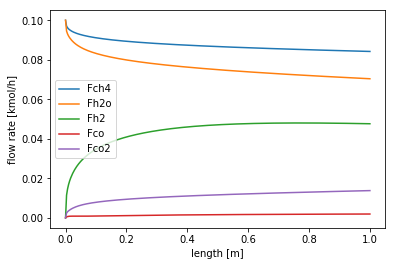

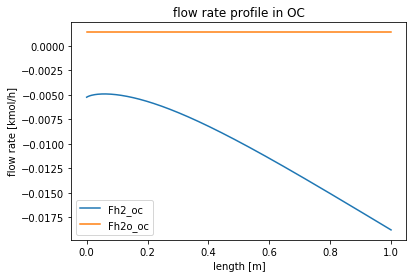

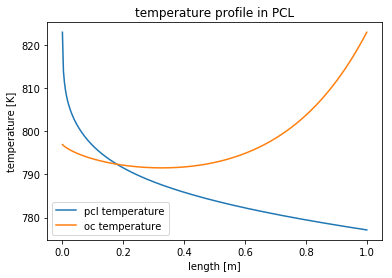

In [3]:
# Take cocurrent case end value as counter current initial guess
Fh2_oc_guess = Fh2_oc[-1]+0.1
# y_oc_guess = y_oc[-1]
T_oc_guess = T_oc[-1]+30


# "ode" function takes in differiential variables and returns the differential equations involved
def ode(Y,Z):
    Fch4,Fh2o,Fh2,Fco,Fco2,Fh2_oc,Fh2o_oc,T,T_oc = Y  # list all the differiential variables

    Ft_oc = Fh2_oc+Fh2o_oc # total flow rate at oc = flow rate of H2 + flow rate of H2O
    Ft = Fch4 + Fh2o + Fh2 + Fco + Fco2 # total flow rate at pcl layer
    Pch4 = Fch4 / Ft * Pt  # patial pressure of CH4
    Ph2o = Fh2o / Ft * Pt  # patial pressure of H2O
    Ph2 = Fh2 / Ft * Pt    # patial pressure of H2
    Pco = Fco / Ft * Pt    # patial pressure of CO
    Pco2 = Fco2 / Ft * Pt  # patial pressure of CO2
    Ph2_oc = Fh2_oc / Ft_oc * Pt_oc  # patial pressure of H2 at oc layer
    Ph2o_oc = Fh2o_oc / Ft_oc * Pt_oc  # patial pressure of H2O at oc layer

    den = 1 + Kco(T) * Pco + Kh2(T) * Ph2 + Kh2o(T) * Ph2o / Ph2   # denominator in kinetics
    r1 = eta1*k1(T)*(Pch4*Ph2o**0.5/Ph2**2.5-Pco*Ph2**0.5/Kp1(T))/den**2 # kmol/(kgcat*h) rate law for reaction 1
    r2 = eta2*k2(T)*(Pco*Ph2o/Ph2-Pco2/Kp2(T))/den**2                    # kmol/(kgcat*h) rate law for reaction 2
    r3 = eta3*k3(T)*(Pch4*Ph2o**2/Ph2**3.5-Pco2*Ph2**0.5/Kp3(T))/den**2  # kmol/(kgcat*h) rate law for reaction 3
    J = Q_mem*np.exp(-E_mem/(R_*T))*(Ph2-Ph2_oc)/d_memb             # kmol/(h*m2) H2 flux

    # kmol/h / m  dF/dZ: flow rate change over reactor length
    dFch4 = (-r1-r3)*rho_cata*(1-epsilon)*Ac_pcl                    
    dFh2o = (-r1-r2-2*r3)*rho_cata*(1-epsilon)*Ac_pcl              
    dFh2 = (3*r1+r2+4*r3)*rho_cata*(1-epsilon)*Ac_pcl - J*2*np.pi*radius1  
    dFco2 = (r2+r3)*rho_cata*(1-epsilon)*Ac_pcl
    dFco = (r1-r2)*rho_cata*(1-epsilon)*Ac_pcl

    dFh2_oc = -J*2*np.pi*radius1  # H2 oc flow rate = inward flux of H2 
    dFh2o_oc = 0   # water is not permeated through membrane, so it does not change

    # 1/m       dy/dZ: nondemensionalized pressure change over reactor length
#     dy = -1/(P0*1e5)*f*G*mu_ave/(rho_ave*d_cata**2)*(1-epsilon)**2/epsilon**3
#     dy_oc = 1/(P0_oc*1e5)*u_oc*4*mu_oc_ave/radius1

    Twall = h_oc/(h_oc+h)*T_oc+h/(h_oc+h)*T     # wall temperature    
    dT = (np.pi*2*radius1*h*(Twall - T)+Ac_pcl*1000/3600*rho_cata*(1-epsilon)*(dH1*r1+dH2*r2+dH3*r3))/(u_pcl*rho_ave*Cp_ave) # K/m pcl temperature change over reactor length
    dT_oc = -(np.pi*2*radius1*h_oc*(Twall - T_oc))/(u_oc*rho_oc_ave*Cp_oc_ave) # K/m oc temperature change over reactor length

    return [dFch4,dFh2o,dFh2,dFco,dFco2,dFh2_oc,dFh2o_oc,dT,dT_oc]
    
# "fun" function takes in guessed left boundary value and returns calculated right boundary value - actual right boundary value
def fun(x):
    Fh2_oc_a,Fh2o_oc_a,T_oc_a = x

    Y0 = [Fch40,Fh2o0,Fh20,Fco0,Fco20,Fh2_oc_a,Fh2o_oc_a,T0,T_oc_a] #left boundary conditions 
    Zspan = np.linspace(0,L1,Dis_num*Col_num+1) # reactor length discretization

    # call odeint to solve the ODE funtions, returns the differential variable value at each discritized length
    sol = odeint(ode,Y0,Zspan)  

    # collect results of differential variables value
    Fch4 = sol[:, 0]
    Fh2o = sol[:, 1]
    Fh2 = sol[:, 2]
    Fco = sol[:, 3]
    Fco2 = sol[:,4]
    Fh2_oc = sol[:,5]
    Fh2o_oc = sol[:,6]
    T_pcl = sol[:,7]
    T_oc = sol[:,8]
    
    # return is expected to be zero
    return [Fh2_oc[-1]-Fh20_oc,Fh2o_oc[-1]-Fh2o0_oc, T_oc[-1]-T0_oc]           

# "fsolve" solve for Fh2,Fh2o,y,T for oc layer at z=0
Fh2_oc_a,Fh2o_oc_a,T_oc_a = fsolve(fun,[Fh2_oc_guess,Fh2o0_oc,T_oc_guess]) # the value in the [] is guessed value

Y0 = [Fch40,Fh2o0,Fh20,Fco0,Fco20,Fh2_oc_a,Fh2o_oc_a,T0,T_oc_a] #left boundary conditions 
Zspan = np.linspace(0,L1,Dis_num*Col_num+1) # reactor length discretization

# call odeint to solve the ODE funtions, returns the differential variable value at each discritized length
sol = odeint(ode,Y0,Zspan)  

# collect results of differential variables value
Fch4 = sol[:, 0]
Fh2o = sol[:, 1]
Fh2 = sol[:, 2]
Fco = sol[:, 3]
Fco2 = sol[:,4]
Fh2_oc = sol[:,5]
Fh2o_oc = sol[:,6]
T_pcl = sol[:,7]
T_oc = sol[:,8]


Ft_oc = Fh2_oc+Fh2o_oc # total flow rate at oc = flow rate of H2 + flow rate of H2O
Ft = Fch4 + Fh2o + Fh2 + Fco + Fco2 # total flow rate at pcl layer
Pch4 = Fch4 / Ft * Pt  # patial pressure of CH4
Ph2o = Fh2o / Ft * Pt  # patial pressure of H2O
Ph2 = Fh2 / Ft * Pt    # patial pressure of H2
Pco = Fco / Ft * Pt    # patial pressure of CO
Pco2 = Fco2 / Ft * Pt  # patial pressure of CO2
Ph2_oc = Fh2_oc / Ft_oc * Pt_oc  # patial pressure of H2 at oc layer
Ph2o_oc = Fh2o_oc / Ft_oc * Pt_oc  # patial pressure of H2O at oc layer

den = 1 + Kco(T) * Pco + Kh2(T) * Ph2 + Kh2o(T) * Ph2o / Ph2   # denominator in kinetics
r1 = eta1*k1(T)*(Pch4*Ph2o**0.5/Ph2**2.5-Pco*Ph2**0.5/Kp1(T))/den**2 # kmol/(kgcat*h) rate law for reaction 1
r2 = eta2*k2(T)*(Pco*Ph2o/Ph2-Pco2/Kp2(T))/den**2                    # kmol/(kgcat*h) rate law for reaction 2
r3 = eta3*k3(T)*(Pch4*Ph2o**2/Ph2**3.5-Pco2*Ph2**0.5/Kp3(T))/den**2  # kmol/(kgcat*h) rate law for reaction 3
J = Q_mem*np.exp(-E_mem/(R_*T))*(Ph2-Ph2_oc)/d_memb             # kmol/(h*m2) H2 flux

# kmol/h / m  dF/dZ: flow rate change over reactor length
dFch4 = (-r1-r3)*rho_cata*(1-epsilon)*Ac_pcl                    
dFh2o = (-r1-r2-2*r3)*rho_cata*(1-epsilon)*Ac_pcl              
dFh2 = (3*r1+r2+4*r3)*rho_cata*(1-epsilon)*Ac_pcl - J*2*np.pi*radius1  
dFco2 = (r2+r3)*rho_cata*(1-epsilon)*Ac_pcl
dFco = (r1-r2)*rho_cata*(1-epsilon)*Ac_pcl

dFh2_oc = -J*2*np.pi*radius1  # H2 oc flow rate = inward flux of H2 
dFh2o_oc = 0   # water is not permeated through membrane, so it does not change

# 1/m       dy/dZ: nondemensionalized pressure change over reactor length
#     dy = -1/(P0*1e5)*f*G*mu_ave/(rho_ave*d_cata**2)*(1-epsilon)**2/epsilon**3
#     dy_oc = 1/(P0_oc*1e5)*u_oc*4*mu_oc_ave/radius1

Twall = h_oc/(h_oc+h)*T_oc+h/(h_oc+h)*T     # wall temperature    
dT = (np.pi*2*radius1*h*(Twall - T)+Ac_pcl*1000/3600*rho_cata*(1-epsilon)*(dH1*r1+dH2*r2+dH3*r3))/(u_pcl*rho_ave*Cp_ave) # K/m pcl temperature change over reactor length
dT_oc = -(np.pi*2*radius1*h_oc*(Twall - T_oc))/(u_oc*rho_oc_ave*Cp_oc_ave)


# making plots below

import matplotlib.pyplot as plt
plt.plot(Zspan,Fch4,label = 'Fch4')
plt.plot(Zspan,Fh2o,label = 'Fh2o')
plt.plot(Zspan,Fh2,label = 'Fh2')
plt.plot(Zspan,Fco,label = 'Fco')
plt.plot(Zspan,Fco2,label = 'Fco2')

plt.ylabel('flow rate [kmol/h]')
plt.xlabel('length [m]')
plt.legend()
plt.show()
# plt.plot(Zspan,x_ch4,label = 'x_Ch4')
# plt.plot(Zspan,x_h2o,label = 'x_H2O')
# plt.plot(Zspan,x_h2,label = 'x_H2')
# plt.plot(Zspan,x_co,label = 'x_CO')
# plt.plot(Zspan,x_co2,label = 'x_CO2')
# plt.title('mole fraction profile in PCL')
# plt.ylabel('mole fraction')
# plt.xlabel('length [m]')
# plt.legend(loc = 'upper right')
# plt.savefig('mole fraction profile in PCL.png')
# plt.show()

plt.plot(Zspan,Fh2_oc,label = 'Fh2_oc')
plt.plot(Zspan,Fh2o_oc,label = 'Fh2o_oc')
plt.ylabel('flow rate [kmol/h]')
plt.xlabel('length [m]')
plt.title('flow rate profile in OC')
plt.savefig('flow rate profile in OC.png')
plt.legend()
plt.show()

plt.plot(Zspan,T,label = 'pcl temperature')
plt.plot(Zspan,T_oc,label = 'oc temperature')
plt.ylabel('temperature [K]')
plt.xlabel('length [m]')
plt.title('temperature profile in PCL')
plt.legend()



plt.show()

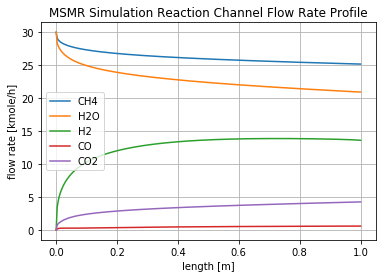

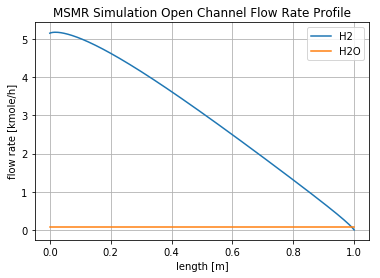

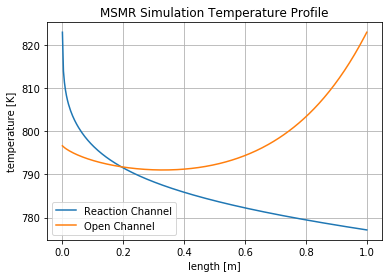

In [4]:
plt.plot(Zspan,Fch4*300,label = 'CH4')
plt.plot(Zspan,Fh2o*300,label = 'H2O')
plt.plot(Zspan,Fh2*300,label = 'H2')
plt.plot(Zspan,Fco*300,label = 'CO')
plt.plot(Zspan,Fco2*300,label = 'CO2')
plt.grid()
plt.ylabel('flow rate [kmol/h]')
plt.xlabel('length [m]')
plt.title('MSMR Simulation Reaction Channel Flow Rate Profile')

plt.legend()
plt.savefig('MSMR Simulation Reaction Channel Flow Rate Profile.png')
plt.show()


plt.plot(Zspan,Fh2_oc*300,label = 'H2')
plt.plot(Zspan,Fh2o_oc*300,label = 'H2O')
plt.ylabel('flow rate [kmole/h]')
plt.xlabel('length [m]')
plt.title('MSMR Simulation Open Channel Flow Rate Profile')

plt.legend()
plt.grid()
plt.savefig('MSMR Simulation Open Channel Flow Rate Profile.png')
plt.show()

plt.plot(Zspan,T,label = 'Reaction Channel')
plt.plot(Zspan,T_oc,label = 'Open Channel')
plt.ylabel('temperature [K]')
plt.xlabel('length [m]')
plt.grid()
plt.title('MSMR Simulation Temperature Profile')
plt.savefig('MSMR Simulation Temperature Profile.png')
plt.legend()



plt.show()

In [572]:
Fch4[-1]*300,Fh2o[-1]*300,Fh2[-1]*300,Fco[-1]*300,Fco2[-1]*300

(25.168895964121376,
 20.91960733608888,
 13.598336859443874,
 0.5848154078460744,
 4.252288628032537)

In [647]:
(Fch4[-1]*300 + Fh2o[-1]*300 + Fco2[-1]*300) / (Fch4[-1]*300 + Fh2o[-1]*300+Fh2[-1]*300+Fco[-1]*300+Fco2[-1]*300)

0.7801877668186332

# Pyomo code

In [573]:
# constraints for reactions:
Ak1 = 4.255e15   # pre-exponential factor of rate constant of reaction 1
Ak2 = 1.955e6    # pre-exponential factor of rate constant of reaction 2
Ak3 = 1.02e15    # pre-exponential factor of rate constant of reaction 3
Ak4a = 2.92e6
Ak4b = 2.46e6
E1 = 240.1       # kJ/mol activation energy of reaction 1
E2 = 67.13       # kJ/mol activation energy of reaction 2
E3 = 243.9       # kJ/mol activation energy of reaction 3
E4a = 86         # kJ/mol activation energy of reaction 4
E4b = 86         # kJ/mol activation energy of reaction 4


R_ = 8.3144621    # J/(K*mol)  gas constant 

dHa = {'CH4': -38.28, 'H2O': 88.68, 'H2': -82.9, 'CO': -70.6} # adsorption enthalpy
AKa = {'CH4': 6.65e-4 , 'H2O': 1.77e5, 'H2': 6.121e-9, 'CO': 8.23e-5} # pre-exponential factor of adsorption constant
dHr = {1:223078, 2:-36584, 3:186494, 4:-802625}  # reaction enthalpy

eta = {1:0.07, 2:0.07, 3:0.06, 4:0.05}          # eta
epsilon = 0.85                                  # bed void fraction

# rho_cata = 1820                                 # kg/m3 catalyst density
# d_cata = 5e-3                                   # m  catalyst diameter
# rho_ave = 1.6                                   # kg/m3  gas average density
# mu_ave = 2.97e-5                                # Pa*s  gas average viscosity
# Cp_ave = 41.06                                  # J/(mol*K) gas mixture specific heat

# Define variables and parameters

In [574]:
def k1(T):        # kmol*bar^(1/2)/(kgcat*hr) rate constant of reaction 1
    return Ak1*pe.exp(-E1/(R*T))
def k2(T):        # kmol/(kgcat*hr)           rate constant of reaction 2
    return Ak2*pe.exp(-E2/(R*T))    
def k3(T):        # kmol*bar^(1/2)/(kgcat*hr) rate constant of reaction 3
    return Ak3*pe.exp(-E3/(R*T)) 
def k4a(T):
    return Ak4a*pe.exp(-E4a/(R*T))
def k4b(T):
    return Ak4b*pe.exp(-E4b/(R*T))
def Ke1(T):       # bar^2   rate equilibrium constant of reaction 1
    return 1.198e17*pe.exp(-26830/T)
def Ke2(T):       #  1      rate equilibrium constant of reaction 2
    return 1.767e-2*pe.exp(4400/T)
def Ke3(T):       # bar^2   rate equilibrium constant of reaction 3
    return 2.117e15*pe.exp(-22430/T)
def Ka(s,T):       # bar^-1  adsorption constant of CO
    return AKa[s]*pe.exp(-dHa[s]/(R*T))

### Pyomo parameters and sets

In [610]:
model = pe.ConcreteModel()

# Parameters
model.L = pe.Param(initialize = L1)  # reactor total length
# model.T0 = pe.Param(initialize = 723) # inlet temperature

# Sets

model.z = dae.ContinuousSet(bounds = (0,model.L))   # z direction
model.SPECIES = pe.Set(initialize = ['CH4','H2O','H2','CO','CO2'])
model.SPECIES_OC = pe.Set(initialize = ['H2','H2O'])
model.REACTIONS = pe.Set(initialize = [1,2,3])

In [611]:
# model.dT = dae.DerivativeVar(model.T, wrt = model.z) # dT/dz
# model.dPt = dae.DerivativeVar(model.Pt, wrt = model.z,initialize = -0.001)
# Rate reformulation term
# model.R1term = pe.Var(model.z) 
# model.R2term = pe.Var(model.z) 
# model.DENterm = pe.Var(model.z) 
# model.R4term1 = pe.Var(model.z) 
# model.R4term2 = pe.Var(model.z) 
# model.R4term3 = pe.Var(model.z) 

# model.Pt0 = pe.Var(bounds = (9,11),initialize = 10) # total pressure

# model.logPH2 = pe.Var(model.z,initialize = 4)

## reactor parameters

In [612]:
model.radius1 = pe.Var(bounds = (1e-3,1e-2))


In [613]:
model.F_in = pe.Var(model.SPECIES, bounds = (1e-5,1), initialize = 20)   # inlet flow rate kmol/h
model.F_in_oc = pe.Var(model.SPECIES_OC, bounds = (1e-5,1))
model.F = pe.Var(model.z, model.SPECIES) # flow rate along reactor
model.F_oc = pe.Var(model.z, model.SPECIES_OC) # flow rate along reactor

 
model.P = pe.Var(model.z, model.SPECIES,initialize = 2) # patial pressure
model.P_oc = pe.Var(model.z, model.SPECIES_OC)
model.Pt = pe.Var(bounds = (8,20)) 
model.Pt_oc = pe.Var(bounds = (1,5))

model.T0 = pe.Var(bounds = (600,1300),initialize = 823)
model.T0_oc = pe.Var(bounds = (600,823),initialize = 823)
model.T = pe.Var(model.z,initialize = 823)# Fix temperature
model.T_oc = pe.Var(model.z)
model.Twall = pe.Var(model.z)


model.Rate = pe.Var(model.z, model.REACTIONS,initialize = 30) # reaction rate
model.DEN = pe.Var(model.z,initialize = 150) # rate Denominator
model.J = pe.Var(model.z)

model.dF = dae.DerivativeVar(model.F, wrt = model.z) # dF/dz
model.dF_oc = dae.DerivativeVar(model.F_oc, wrt = model.z)

model.dT = dae.DerivativeVar(model.T, wrt = model.z)
model.dT_oc = dae.DerivativeVar(model.T_oc, wrt = model.z)


In [614]:
model.F_in['CH4'].fix(0.1)
# model.F_in['H2O'].fix(0.01)
model.F_in['H2O'] = 0.06
model.F_in['H2'].fix(1e-5)
model.F_in['CO'].fix(1e-5)
model.F_in['CO2'].fix(1e-5)

model.F_in_oc['H2'].fix(1e-5)
# model.F_in_oc['H2O'].fix(3e-4)

In [615]:
# model.T0.fix(823)
# model.T0_oc.fix(823)
# model.Pt.fix(10)
# model.Pt_oc.fix(1)

model.radius1.fix(7e-3)

In [616]:
# ODEs Constraints

# def Pressure_nondimensionalize_rule(m,z):  # total pressure of pcl = nondementionalized pressure of pcl * Initial pressure of pcl, here y = P0/P
#     return m.Pt[z] == m.y* m.P0
# model.Pressure_nondimensionalize = pe.Constraint(model.z, rule = Pressure_nondimensionalize_rule)

# def Total_Flow_rule(m,z): # total flow rate is sum of single species flow rate
#     return m.Ft[z] == sum(m.F[z,s] for s in model.SPECIES)
# model.Total_Flow = pe.Constraint(model.z, rule = Total_Flow_rule)

def Patial_pressure_rule(m,z,s):  # patial pressure
    return m.P[z,s] * sum(m.F[z,sp] for sp in model.SPECIES) == m.F[z,s] * m.Pt
model.Patial_pressure = pe.Constraint(model.z, model.SPECIES, rule =  Patial_pressure_rule)

def Patial_pressure_oc_rule(m,z,s):  # patial pressure
    return m.P_oc[z,s] * sum(m.F_oc[z,sp] for sp in model.SPECIES_OC) == m.F_oc[z,s] * m.Pt_oc
model.Patial_pressure_oc = pe.Constraint(model.z, model.SPECIES_OC, rule =  Patial_pressure_oc_rule)

In [617]:
def Def_DEN_rule(m,z):  # define DEN
    return m.DEN[z] == 1 + Ka('CO',m.T[z])*m.P[z,'CO'] + Ka('CH4',m.T[z])*m.P[z,'CH4'] + Ka('H2',m.T[z])*m.P[z,'H2'] +\
            Ka('H2O',m.T[z])*m.P[z,'H2O']/m.P[z,'H2']
model.Def_DEN = pe.Constraint(model.z, rule =  Def_DEN_rule)


def Def_Rate1_rule(m,z):   # kmol/(kgcat*h) rate law for reaction 1
    return m.Rate[z,1] * m.DEN[z]**2 == eta[1] * k1(m.T[z])*(m.P[z,'CH4']*m.P[z,'H2O']/m.P[z,'H2']**2.5-\
                                            m.P[z,'CO']*m.P[z,'H2']**0.5/Ke1(m.T[z]))
model.Def_Rate1 = pe.Constraint(model.z, rule =  Def_Rate1_rule)

def Def_Rate2_rule(m,z):   # kmol/(kgcat*h) rate law for reaction 2
    return m.Rate[z,2]*m.DEN[z]**2 == eta[2] * k2(m.T[z])*(m.P[z,'CO']*m.P[z,'H2O']/m.P[z,'H2']-m.P[z,'CO2']/Ke2(m.T[z]))
model.Def_Rate2 = pe.Constraint(model.z, rule =  Def_Rate2_rule)

def Def_Rate3_rule(m,z):
    return m.Rate[z,3]*m.DEN[z]**2 == eta[3] * k3(m.T[z])*(m.P[z,'CH4']*m.P[z,'H2O']**2/m.P[z,'H2']**3.5-\
                                            m.P[z,'CO2']*m.P[z,'H2']**0.5/Ke3(m.T[z]))
model.Def_Rate3 = pe.Constraint(model.z, rule =  Def_Rate3_rule)

# def Def_Rate4_rule(m,z):   # kmol/(kgcat*h) rate law for reaction 1
#     return m.Rate[z,4]== eta[4]*(k4a(m.T[z])*m.P[z,'CH4']*m.P[z,'O2']/(1+Kox_CH4(m.T[z])*m.P[z,'CH4']+\
#                          Kox_O2(m.T[z])*m.P[z,'O2'])**2+ k4b(m.T[z])*m.P[z,'CH4']*m.P[z,'O2']\
#                                  /(1+Kox_CH4(m.T[z])*m.P[z,'CH4']+Kox_O2(m.T[z])*m.P[z,'O2']))
# model.Def_Rate4 = pe.Constraint(model.z, rule =  Def_Rate4_rule)

def Def_J_rule(m,z):
    return m.J[z] == Q_mem*pe.exp(-E_mem/(R_*m.T[z]))*(m.P[z,'H2']-m.P_oc[z,'H2'])/d_memb   
model.Def_J = pe.Constraint(model.z, rule = Def_J_rule)

In [618]:
# def Def_dPt_rule(m,z):
#     return m.dPt[z] == -1/1e5*f_ave*u_ave*mu_ave/(d_cata**2)*(1-epsilon)**2/epsilon**3 
# model.Def_dPt = pe.Constraint(model.z, rule =  Def_dPt_rule)


In [619]:
def Def_FCH4_rule(m,z):
    return m.dF[z,'CH4'] ==  (-m.Rate[z,1]-m.Rate[z,3])*rho_cata*(1-epsilon)*Ac_pcl
model.Def_FCH4 = pe.Constraint(model.z, rule =  Def_FCH4_rule)

def Def_FH2O_rule(m,z):
    return m.dF[z,'H2O'] ==  (-m.Rate[z,1]-m.Rate[z,2]+2*m.Rate[z,3])*rho_cata*(1-epsilon)*Ac_pcl
model.Def_FH2O = pe.Constraint(model.z, rule =  Def_FH2O_rule)

def Def_FH2_rule(m,z):
    return m.dF[z,'H2'] ==  (3*m.Rate[z,1]+m.Rate[z,2]+4*m.Rate[z,3])*rho_cata*(1-epsilon)*Ac_pcl -model.J[z]*2*3.141592653589793*m.radius1
model.Def_FH2 = pe.Constraint(model.z, rule =  Def_FH2_rule)

def Def_FCO_rule(m,z):
    return m.dF[z,'CO'] ==  (m.Rate[z,1]-m.Rate[z,2])*rho_cata*(1-epsilon)*Ac_pcl
model.Def_FCO = pe.Constraint(model.z, rule =  Def_FCO_rule)

def Def_FCO2_rule(m,z):
    return m.dF[z,'CO2'] ==  (m.Rate[z,2]+m.Rate[z,3])*rho_cata*(1-epsilon)*Ac_pcl
model.Def_FCO2 = pe.Constraint(model.z, rule =  Def_FCO2_rule)

 # model

def Def_FH2O_oc_rule(m,z):
    return m.dF_oc[z,'H2O'] ==  0
model.Def_FH2O_oc = pe.Constraint(model.z, rule =  Def_FH2O_oc_rule)

def Def_FH2_oc_rule(m,z):
    return m.dF_oc[z,'H2'] ==  -model.J[z]*2*3.141592653589793*m.radius1
model.Def_FH2_oc = pe.Constraint(model.z, rule =  Def_FH2_oc_rule)


def H2CORatio_rule(m):    
    yield m.F[m.L,'H2'] >= 1.98* m.F[m.L,'CO']
    yield m.F[m.L,'H2'] <= 2.07* m.F[m.L,'CO']
model.H2CORatio = pe.ConstraintList(rule =  H2CORatio_rule)

def H2O_oc_inlet_rule(m):
    return m.F_in_oc['H2O'] >= 0.0003
model.H2O_oc_inlet = pe.Constraint(rule = H2O_oc_inlet_rule)

In [620]:
def Def_Twall_rule(m,z):
    return m.Twall[z] == h_oc/(h_oc+h)*m.T_oc[z] + h/(h_oc+h)*m.T[z] 
model.Def_Twall = pe.Constraint(model.z, rule =  Def_Twall_rule)

def Def_dT_rule(m,z):
    return m.dT[z] == (np.pi*2*m.radius1*h*(m.Twall[z] - m.T[z])+Ac_pcl*1000/3600*rho_cata*(1-epsilon)\
           *(-1)*(sum(dHr[r]*m.Rate[z,r] for r in model.REACTIONS)))/(u_pcl*rho_ave*Cp_ave)  
model.Def_dT = pe.Constraint(model.z, rule =  Def_dT_rule)

def Def_dT_oc_rule(m,z):
    return m.dT_oc[z] == -(np.pi*2*m.radius1*h_oc*(m.Twall[z] - m.T_oc[z]))/(u_oc*rho_oc_ave*Cp_oc_ave)  
model.Def_dT_oc = pe.Constraint(model.z, rule =  Def_dT_oc_rule)

In [621]:
# Initial conditions

def InitCon_rule(m):
    for s in model.SPECIES:
        yield m.F[0,s] == m.F_in[s]
    for soc in model.SPECIES_OC:
        yield m.F_oc[m.L,soc] == m.F_in_oc[soc]
    yield m.T[0] == m.T0
    yield m.T_oc[m.L] == m.T0_oc
model.InitCon = pe.ConstraintList(rule = InitCon_rule)

# Dummy optimize function
model.Imp = pe.Var()

def Impurity_rule(m):
    return m.Imp == (m.F[m.L,'CO2'] + m.F[m.L,'H2O'] + m.F[m.L,'CH4'])/sum(m.F[m.L,sp] for sp in model.SPECIES)
model.Impurity = pe.Constraint(rule =  Impurity_rule)

In [622]:
# def Objective_rule(m):
#     return m.F[m.L,'H2']
# model.obj = pe.Objective(rule = Objective_rule,sense = pe.maximize ) # Dummy Objective

In [623]:
# def Objective_rule(m):
#     return m.F[m.L,'CO2']
# model.obj = pe.Objective(rule = Objective_rule,sense = pe.minimize ) # Dummy Objective

In [624]:
def Objective2_rule(m):
    return m.Imp
model.obj = pe.Objective(rule = Objective2_rule,sense = pe.minimize ) # Dummy Objective

In [625]:
discretizer = pe.TransformationFactory('dae.collocation')
discretizer.apply_to(model,nfe=Dis_num,ncp=Col_num,scheme='LAGRANGE-RADAU')

In [626]:
zspan = list(model.z)
for i in range(Dis_num*Col_num+1):
    x = zspan[i]
    model.F[x,'CH4'] = Fch4[i]
    model.F[x,'H2O'] = Fh2o[i]
    model.F[x,'CO'] = Fco[i]
    model.F[x,'H2'] = Fh2[i]
    model.F[x,'CO2'] = Fco2[i]
    model.F_oc[x,'H2'] = Fh2_oc[i]
    model.F_oc[x,'H2O'] = Fh2o_oc[i]


    model.P[x,'CH4'] = Pch4[i]
    model.P[x,'H2O'] = Ph2o[i]
    model.P[x,'CO'] = Pco[i]
    model.P[x,'H2'] = Ph2[i]
    model.P[x,'CO2'] = Pco2[i]
    
    model.T[x] = T[i]
    model.T_oc[x] = T_oc[i]
    
    model.P_oc[x,'H2'] = Ph2_oc[i]
    model.P_oc[x,'H2O'] = Ph2o_oc[i]
    model.Rate[x,1] = r1[i]
    model.Rate[x,2] = r2[i]
    model.Rate[x,3] = r3[i]
    model.DEN[x] = den[i]
    model.J[x] = J[i]
    
    
#     model.R1term[x] = r1term[i]
#     model.R2term[x] = r2term[i]
#     model.DENterm[x] = denterm[i]
#     model.R4term1[x] = r4term1[i]
#     model.R4term2[x] = r4term2[i]
#     model.R4term3[x] = r4term3[i]
    model.dF[x,'CH4'] = dFch4[i]
    model.dF[x,'H2O'] = dFh2o[i]
    model.dF[x,'CO'] = dFco[i]
    model.dF[x,'H2'] = dFh2[i]
    model.dF[x,'CO2'] = dFco2[i]
    model.dF_oc[x,'H2'] = dFh2_oc[i]
    model.dF_oc[x,'H2O'] = dFh2o_oc
    model.dT[x] = dT[i]
    model.dT_oc[x] = dT_oc[i]


In [627]:
import os
cdir = os.getcwd()
solver = pe.SolverFactory('gams')
options = {'warmstart':True,'solver':'conopt4','mtype':'nlp','symbolic_solver_labels':True,
            'add_options':['GAMS_MODEL.OptFile=1;','GAMS_MODEL.workspace=8000;','GAMS_MODEL.ResLim = 200;' ]}
results = solver.solve(model, logfile='solver.log', tee = True,tmpdir = cdir,io_options=options)

--- Job model.gms Start 12/11/19 10:09:16 25.0.3 r65947 WEX-WEI x86 64bit/MS Windows
GAMS 25.0.3   Copyright (C) 1987-2018 GAMS Development. All rights reserved
*** License File has expired 8 days ago
Licensee: Nikolaos Sahinidis, Single User License        G190107/0001AB-GEN
          Carnegie Mellon University, Dept of Chemical Engineering.  DC8887
          License for teaching and research at degree granting institutions
          sahinidis@cmu.edu                                                
--- Starting compilation
--- model.gms(55804) 12 Mb
--- Starting execution: elapsed 0:00:00.237
--- model.gms(37072) 13 Mb
--- Generating NLP model GAMS_MODEL
--- model.gms(37076) 18 Mb
---   9,336 rows  9,339 columns  45,733 non-zeroes
---   72,254 nl-code  21,677 nl-non-zeroes
--- model.gms(37076) 16 Mb
--- Executing CONOPT4: elapsed 0:00:00.885
--- model.gms(37076) 15 Mb

CONOPT 4         25.0.3 r65947 Released Mar 21, 2018 WEI x86 64bit/MS Windows 
*** Error Cannot open parameter file "

In [628]:
if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
    print('Optimal solution found')
elif (results.solver.termination_condition == TerminationCondition.infeasible):
    print('problem infeasible')
else:
    print(f'Solver Status: {results.solver.status}')

Solver Status: ok


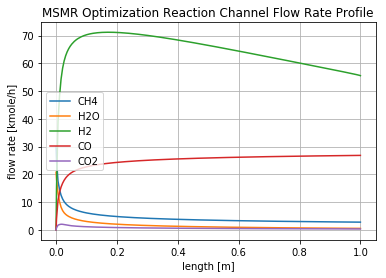

In [629]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.plot(Zspan,Fch4,label = 'Fch4')
# plt.plot(Zspan,Fh2o,label = 'Fh2o')
# plt.plot(Zspan,Fh2,label = 'Fh2')
# plt.plot(Zspan,Fco,label = 'Fco')
# plt.plot(Zspan,Fco2,label = 'Fco2')
# plt.plot(Zspan,Fo2,label = 'Fo2')
# plt.ylabel('flow rate [kmole/h]')
# plt.xlabel('length [m]')
# plt.legend()

F = [[pe.value(model.F[i,s])*300 for s in model.SPECIES] for i in model.z ] 
plt.plot(zspan,F)
plt.legend(list(model.SPECIES))
plt.ylabel('flow rate [kmol/h]')
plt.xlabel('length [m]')
plt.title('MSMR Optimization Reaction Channel Flow Rate Profile')

plt.grid()
plt.savefig('MSMR_opt_F.png')
# plt.ylim([15,30])
plt.show()

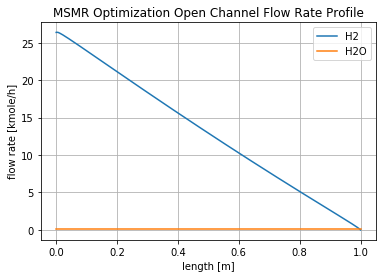

In [630]:
F_oc = [[pe.value(model.F_oc[i,s]*300) for s in model.SPECIES_OC] for i in model.z ]
plt.plot(zspan,F_oc)
plt.legend(list(model.SPECIES_OC))
plt.ylabel('flow rate [kmol/h]')
plt.xlabel('length [m]')
plt.title('MSMR Optimization Open Channel Flow Rate Profile')

plt.grid()
# plt.ylim([15,30])
plt.savefig('MSMR_opt_OCF.png')
plt.show()


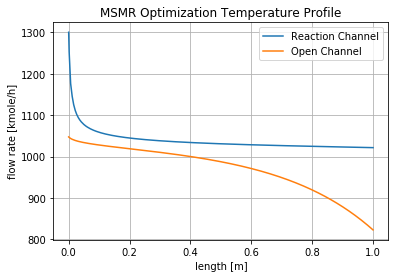

In [631]:
T_pyo= [pe.value(model.T[i]) for i in model.z]
T_oc_pyo= [pe.value(model.T_oc[i]) for i in model.z]
plt.plot(zspan,T_pyo,label = 'Reaction Channel')
plt.plot(zspan,T_oc_pyo,label = 'Open Channel')

plt.ylabel('flow rate [kmol/h]')
plt.xlabel('length [m]')
plt.title('MSMR Optimization Temperature Profile')
plt.legend()
plt.grid()
plt.savefig('MSMR_opt_T.png')
# plt.ylim([15,30])
plt.show()

In [55]:

# def Def_DEN_rule(m,z):  # define DEN
#     return m.DEN[z] == 1 + Ka('CO',m.T[z])*m.P[z,'CO'] + Ka('CH4',m.T[z])*m.P[z,'CH4'] + Ka('H2',m.T[z])*m.P[z,'H2'] + m.DENterm[z]
# model.Def_DEN = pe.Constraint(model.z, rule =  Def_DEN_rule)

# def Def_DENterm_rule(m,z):
#     return m.DENterm[z] * m.P[z,'H2'] ==  Ka('H2O',m.T[z]) * m.P[z,'H2O']
# model.Def_DENterm = pe.Constraint(model.z, rule =  Def_DENterm_rule)

# def Def_Rate1_rule(m,z): 
#     return m.Rate[z,1] * m.DEN[z]**2 * pe.exp(2.5*m.logPH2[z]) == eta[1] * k1(m.T[z])*(m.P[z,'CH4']*m.P[z,'H2O'] - m.R1term[z])
# model.Def_Rate1 = pe.Constraint(model.z, rule =  Def_Rate1_rule)

# def Def_Rate1term_rule(m,z):  
#     return m.R1term[z] * Ke1(m.T[z]) == m.P[z,'H2']**3 - m.P[z,'CO']
# model.Def_Rate1term = pe.Constraint(model.z, rule =  Def_Rate1term_rule)

# def Def_H2half_rule(m,z):  
#     return m.P[z,'H2'] == pe.exp(m.logPH2[z])
# model.Def_H2half = pe.Constraint(model.z, rule =  Def_H2half_rule)
    
    
# def Def_Rate2_rule(m,z): 
#     return m.Rate[z,2] * m.DEN[z]**2 * m.P[z,'H2'] == eta[2] * k2(m.T[z])*(m.P[z,'CO']*m.P[z,'H2O']-m.R2term[z])
# model.Def_Rate2 = pe.Constraint(model.z, rule =  Def_Rate2_rule)

# def Def_Rate2term_rule(m,z): 
#     return m.R2term[z] * Ke2(m.T[z]) == m.P[z,'H2'] * m.P[z,'CO2']
# model.Def_Rate2term = pe.Constraint(model.z, rule =  Def_Rate2term_rule)

# def Def_Rate4_rule(m,z): 
#     if pe.value(m.F[z,'O2']) > 1e-7:
#         return m.Rate[z,4] == eta[4] * (m.R4term1[z] + m.R4term2[z])
#     return m.Rate[z,4] == 0
# model.Def_Rate4 = pe.Constraint(model.z, rule =  Def_Rate4_rule)

# def Def_Rate4term1_rule(m,z): 
#     if pe.value(m.F[z,'O2']) > 1e-7:
#         return m.R4term1[z] * m.R4term3[z]**2 == k4a(m.T[z]) * m.P[z,'CH4'] * m.P[z,'O2']
#     return m.R4term1[z] == 0
# model.Def_Rate4term1 = pe.Constraint(model.z, rule =  Def_Rate4term1_rule)


# def Def_Rate4term2_rule(m,z): 
#     if pe.value(m.F[z,'O2']) > 1e-7:
#         return m.R4term2[z] * m.R4term3[z] ==  k4b(m.T[z]) * m.P[z,'CH4'] * m.P[z,'O2']
#     return m.R4term2[z] == 0
# model.Def_Rate4term2 = pe.Constraint(model.z, rule =  Def_Rate4term2_rule)

# def Def_Rate4term3_rule(m,z):   
#     if pe.value(m.F[z,'O2']) > 1e-7:
#         return m.R4term3[z] ==1 + Kox_CH4(m.T[z]) * m.P[z,'CH4'] + Kox_O2(m.T[z]) * m.P[z,'O2']
#     return m.R4term3[z] == 1 + Kox_CH4(m.T[z]) * m.P[z,'CH4']
# model.Def_Rate4term3 = pe.Constraint(model.z, rule =  Def_Rate4term3_rule)